# VAE: Image Encoder

In [1]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
#config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


##  Build VAE
Define Parameters

In [2]:
latent_dim = 2         #Dimension of the embedding space
input_shape=(28,28,1)  #Shape of each video frame
d = input_shape[0]
beta = K.variable(5e-2) #hyperparemeter controlling regularization of latent space
pix_loss = 'mse'       #consider setting to 'binary' if binarized image

Build the model

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class setBeta(keras.callbacks.Callback):
    """"Allows the latent regularization to increase over epochs (find good embedding then contract)"""
    def __init__(self, beta,):
        self.beta = beta
    def f(self,epoch):
        beq = 1e-1
        b0 = 5e-3
        return beq-(beq-b0)*.95**epoch
    def on_epoch_begin(self, epoch, logs={}):
        K.set_value(self.beta, self.f(epoch))
        

def network_encoder(x, latent_dim=2):
    """build encoder"""
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return z_mean, z_log_var, z


def network_decoder(x): #to do--make sure output matches input shape
    """build decoder"""
    x = layers.Dense(d//4 * d//4 * 64, activation="relu")(x)
    x = layers.Reshape((d//4, d//4, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    if pix_loss == 'binary':
        decoder_outputs = layers.Conv2DTranspose(input_shape[-1], 3, activation="sigmoid", padding="same")(x) 
    elif pix_loss == 'mse':
        decoder_outputs = layers.Conv2DTranspose(input_shape[-1], 3, activation="linear", padding="same")(x)
    return decoder_outputs


#Build encoder model
encoder_input = keras.layers.Input(input_shape)
z_mean, z_log_var, z = network_encoder(encoder_input,latent_dim=latent_dim)
encoder = keras.models.Model(encoder_input, z_mean, name='encoder')
#encoder.summary()

#Build decoder model
decoder_input = keras.layers.Input((latent_dim,))
decoder_output = network_decoder(decoder_input)
decoder = keras.models.Model(decoder_input,decoder_output)
reconstruction = decoder(z)

def custom_loss_wrapper(z_mean=z_mean,z_log_var=z_log_var):
    """"Returns the loss function for keras training"""
    def loss(y_true, y_pred):
        if pix_loss == 'binary':
            reconstruction_loss = tf.reduce_mean(
                        keras.losses.binary_crossentropy(y_true,y_pred))          
            reconstruction_loss *= d**2
        elif pix_loss == 'mse':
            reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_true,y_pred,))
            reconstruction_loss *= d**2
        
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -beta
        return reconstruction_loss + kl_loss
    return loss

def reconstruction_loss(y_true, y_pred):
    if pix_loss == 'binary':
        reconstruction_loss = tf.reduce_mean(
                    keras.losses.binary_crossentropy(y_true,y_pred)
                )  ###TODO change to MSE for non-bbinary img            
        reconstruction_loss *= d**2
    elif pix_loss == 'mse':
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_true,y_pred,))
        reconstruction_loss *= d**2
    return reconstruction_loss

def KL_loss_wrapper(z_mean=z_mean,z_log_var=z_log_var):
    def KLloss(y_true, y_pred):
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -beta
        return kl_loss
    return KLloss

# compile model
model = keras.models.Model(encoder_input,reconstruction)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss_wrapper(z_mean,z_log_var),
              metrics=[reconstruction_loss,
                       KL_loss_wrapper(z_mean,z_log_var)])

### Load dataset and train

Epoch 1/20
96562/96562 [==============================] - 5s 47us/step - loss: 2.5033 - reconstruction_loss: 2.5027 - KLloss: 2.8807e-05
Epoch 2/20
96562/96562 [==============================] - 4s 43us/step - loss: 1.9547 - reconstruction_loss: 1.9547 - KLloss: 1.7367e-05
Epoch 3/20
96562/96562 [==============================] - 4s 42us/step - loss: 1.9519 - reconstruction_loss: 1.9517 - KLloss: 3.2880e-05
Epoch 4/20
96562/96562 [==============================] - 4s 43us/step - loss: 1.9530 - reconstruction_loss: 1.9527 - KLloss: 5.6712e-05
Epoch 5/20
96562/96562 [==============================] - 4s 42us/step - loss: 1.9522 - reconstruction_loss: 1.9521 - KLloss: 8.8172e-05
Epoch 6/20
96562/96562 [==============================] - 4s 42us/step - loss: 1.9511 - reconstruction_loss: 1.9511 - KLloss: 1.0711e-04
Epoch 7/20
96562/96562 [==============================] - 4s 43us/step - loss: 1.9511 - reconstruction_loss: 1.9509 - KLloss: 1.0368e-04
Epoch 8/20
96562/96562 [=================

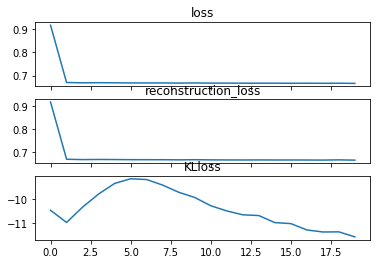

Text(0.5, 1.0, 'reconstructed')

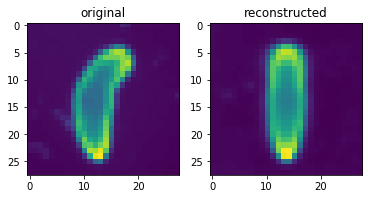

In [11]:
data = np.load('hiResImg_align_28v2.npy').astype("float32")
data = data/data.max()
#mnist_digits = np.load('otherData/CPC_prepped/hiResImg_64.npy').astype("float32")[:,:,:,None] / 255
history = model.fit(x=data,y=data, epochs=20, batch_size=128, callbacks=[setBeta(beta)])

pred = model.predict(data[:])
latent = encoder.predict(data)
fig, ax = plt.subplots(nrows=3,sharex=True)
for i,k in enumerate(history.history.keys()):
    ax[i].plot(np.log(history.history[k]))
    ax[i].set_title(k)
plt.show()

k=1900*2
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(data[k,:,:,0])
ax[1].imshow(pred[k,:,:,0])
ax[0].set_title('original')
ax[1].set_title('reconstructed')

*** The KL loss will likely increase over time due to the $\beta$ regularizer schedule

